In [1]:
from ProcessingEmbeddings import *
from HardDebias import *
from DoubleHardDebias import *
from utils import *

In [2]:
import codecs
import json
import numpy as np
import sklearn
from sklearn.svm import LinearSVC, SVC


In [3]:
glove=Embeddings('glove-wiki-gigaword-50')

Loading glove-wiki-gigaword-50 embeddings
vectors shape: (400000, 50), word2idx length: 400000, vocab length: 400000


In [4]:
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
np.isnan(vectors).any()

False

In [6]:
#Gender specific vocabulary:
gender_specific=[]
with open('./Data/male_word_file.txt') as f:
    gender_specific = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

In [7]:
# Getting a limited vocabulary to debias the embeddings.
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab, exclude=gender_specific)

100%|██████████| 400000/400000 [00:00<00:00, 633311.12it/s]


Size of limited vocabulary: 326614


In [8]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian"],
		["african", "caucasian", "asian"],
		["black", "white", "asian"],
		["africa", "america", "asia"],
		["africa", "america", "china"],
		["africa", "europe", "asia"]
    ], 
    "religion":[
		["judaism", "christianity", "islam"],
		["jew", "christian", "muslim"],
    ["synagogue", "church", "mosque"],
    ["torah", "bible", "quran"],
    ["rabbi", "priest", "imam"]
	]}

In [9]:
#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race and religion where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], ["brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman", "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], ["gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], ["his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], ["men", "women"], ["nephew", "niece"], ["prince", "princess"], 
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]],

    "race": [
        ["black", "caucasian", "asian"],
      	["african", "caucasian", "asian"],
      	["black", "white", "asian"],
      	["africa", "america", "asia"],
      	["africa", "america", "china"],
      	["africa", "europe", "asia"]
    ],
    "religion": [
        ["judaism", "christianity", "islam"],
        ["jew", "christian", "muslim"],
        ["synagogue", "church", "mosque"],
        ["torah", "bible", "quran"],
        ["rabbi", "priest", "imam"]
    ]}


In [10]:
#Some of the words were taken from the analogies' templates from Cheng and Manzini. 
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories. 
neutral_words=["manager", "executive", "doctor", "lawyer", "programmer", 
	       "scientist", "soldier", "supervisor", "rancher", "janitor",
	        "firefighter", "officer","secretary", "nurse", "clerk", "artist",
	        "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist", 
	        "receptionist", "counselor", "leader", "farmer",
 			"engineer", "laborer", "teacher",
 			"slave", "musician", "runner", "criminal", "homeless",
            "greedy", "cheap", "hairy", "liberal", 
            "judgemental", "conservative", "familial",
  		    "violent", "terrorist", "dirty", "uneducated", "educated"]


### Hard-Debias Algorithm

#### Gender

In [11]:
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

In [12]:
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])
def_set_religion=utils.prepare_def_sets_subspace(def_sets["religion"])

In [13]:
import HardDebias as hd

In [14]:
debiased_vectors, debiased_vocab, debiased_word2idx= hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             centralizing=True)

Length of vectors set: 22
Running PCA with 1 components


In [15]:
debiased_dict=get_debiased_dict(debiased_vectors, debiased_word2idx)

## Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")



## Evaluation

In [16]:
from Visualization import *
from Evaluation import *

### Gender Bias Pre-Post

In [ ]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
gender_bias_original = compute_gender_simple_bias(dict_vec_cleaned, he_embed, she_embed)

In [ ]:
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)


In [ ]:
gender_bias_original2 = compute_direct_bias(
    dict_vectors, vocab_cleaned, gender_direction)


In [ ]:
compute_average_bias(debiased_dict, neutral_words, gender_direction)


In [ ]:
import pandas as pd

In [ ]:
gender_bias_original2 = compute_direct_bias(
    debiased_dict, neutral_words, gender_direction)

In [ ]:
gender_bias_after_debiasing=compute_gender_simple_bias(debiased_dict, he_embed, she_embed)

In [ ]:
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']


In [ ]:
def get_bias_score_df_from_list(bias_scores_original, debiased_scores, word_list, vocab_cleaned, debiased_vocab_limited):
    word_set = set(vocab_cleaned)
    word_set_debiased = set(debiased_vocab_limited)
    scores = {}
    for word in word_list:
        if word in word_set:
            scores[word] = {"original_score": bias_scores_original[word]}
        if word in word_set_debiased:
            scores[word] = scores.get(word, {})
            scores[word]["debiased_score"] = debiased_scores[word]

    full_scores_df = pd.DataFrame.from_dict(
        scores, orient='index').reset_index()

    full_scores_df_long = pd.melt(full_scores_df, id_vars=["index"], value_vars=[
                                  "original_score", "debiased_score"])
    full_scores_df_long["value"].astype("float")

    return full_scores_df_long


In [ ]:
bias_df=get_bias_score_df_from_list(gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,debiased_vocab)
plot_bias_bar(bias_df)

In [ ]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(gender_bias_original, def_sets['gender'], 1000, word2idx)


In [ ]:
def extract_vectors(words, vectors, w2i):

    X = [vectors[w2i[x], :] for x in words]

    return X


In [ ]:
def visualize(vectors, y_true, y_pred, ax, title):
    # perform TSNE
    vectors = utils.normalize(vectors)
    X_embedded = TSNE(
        n_components=2, random_state=RANDOM_STATE).fit_transform(vectors)
    for x, p, y in zip(X_embedded, y_pred, y_true):
        if y:
            ax.scatter(x[0], x[1], marker='.', c='c')
        else:
            ax.scatter(x[0], x[1], marker='x', c='darkviolet')

    return ax


In [ ]:
def cluster_and_visualize(words, X1, title, y_true, num=2):

    kmeans_1 = KMeans(n_clusters=num, random_state=RANDOM_STATE).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (
        item1, item2) in zip(y_true, y_pred_1)]
    print('precision', max(sum(correct)/float(len(correct)),
          1 - sum(correct)/float(len(correct))))

    fig, axs = plt.subplots(1, 1, figsize=(6, 3))
    ax1 = visualize(X1, y_true, y_pred_1, axs, title)


In [ ]:
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      gendered_vectors, 'GloVe_original', y_true)


In [ ]:
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, debiased_vectors, debiased_word2idx)

cluster_and_visualize(male_words + female_words, gendered_debiased_vectors,
                      'Debiased_GloVe', y_true)


###  Random Words: bias scores and neighbors

In [17]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=20)

#setting parameters for the gensim method "most_similar"
topn = 3


In [18]:
random_words

array(['weaponry', 'decora', 'zittel', 'concealment', 'hathi', 'camphora',
       'zammit', 'tihipko', 'repressively', 'flynns', 'milad', 'xiangxi',
       'raiola', 'jasper', 'chữ', 'deg', 'iressa', 'halyburton',
       'kaverin', 'mchaney'], dtype='<U19')

In [19]:
#Gensim's .most_similar() method finds the top-N most similar words to a given word.
#See documentation: https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
glove.model.most_similar(random_words[0], topn=topn)


[('weapons', 0.8506980538368225),
 ('missiles', 0.7991170883178711),
 ('armaments', 0.7926740050315857)]

In [20]:
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)
model_debiased = create_KeyedVectors(debiased_vectors, debiased_vocab, 50)

In [21]:
model_original.most_similar(random_words[0], topn=2)


[('weapons', 0.8506980538368225), ('missiles', 0.7991170883178711)]

In [22]:

words_before_after=finding_neighbors_before_after(random_words, model_original, model_debiased, topn=topn)

----------------------------------
word: weaponry
 most-similar-before: ('weapons', 'missiles', 'armaments')
 most-similar-after: ('potlatches', 'heijden', 'easiest')
----------------------------------
word: decora
 most-similar-before: ('encyclia', 'coelogyne', 'pisidium')
 most-similar-after: ('youngworth', 'belliard', 'rezze')
----------------------------------
word: zittel
 most-similar-before: ('lorente', 'palladio', 'tafi')
 most-similar-after: ('giacomelli', 'smoker', 'bedclothes')
----------------------------------
word: concealment
 most-similar-before: ('deception', 'subterfuge', 'deceit')
 most-similar-after: ('wagn', 'kaverin', 'femaleness')
----------------------------------
word: hathi
 most-similar-before: ('holborne', 'martillo', 'segen')
 most-similar-after: ('costco', 'kulen', 'indrapuri')
----------------------------------
word: camphora
 most-similar-before: ('cinnamomum', 'melanoxylon', 'wodan')
 most-similar-after: ('rustics', 'abhorrence', 'komaba')
-------------

In [23]:
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(keys, model_original, model_debiased, topn)


In [24]:
from sklearn.manifold import TSNE
import numpy as np


n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


/Users/angeladuarte/Python/VersionControl/MT_DebiasingAlgorithms/Visualization.py:93: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


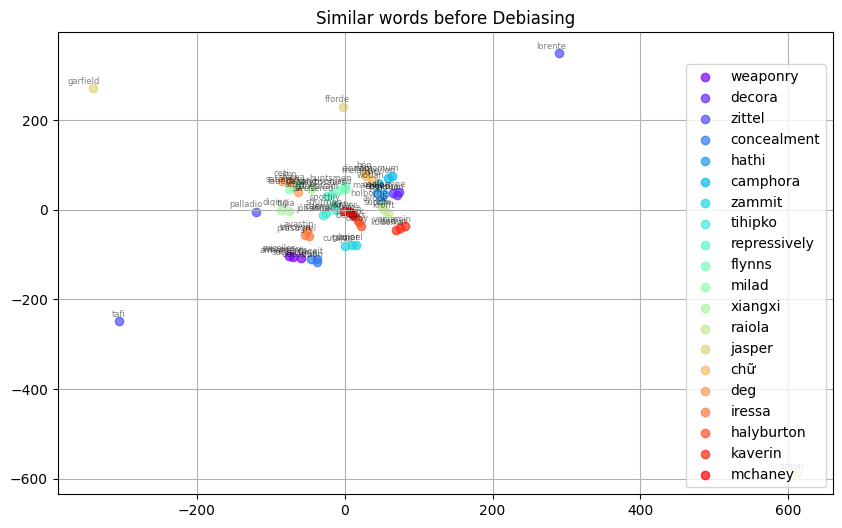

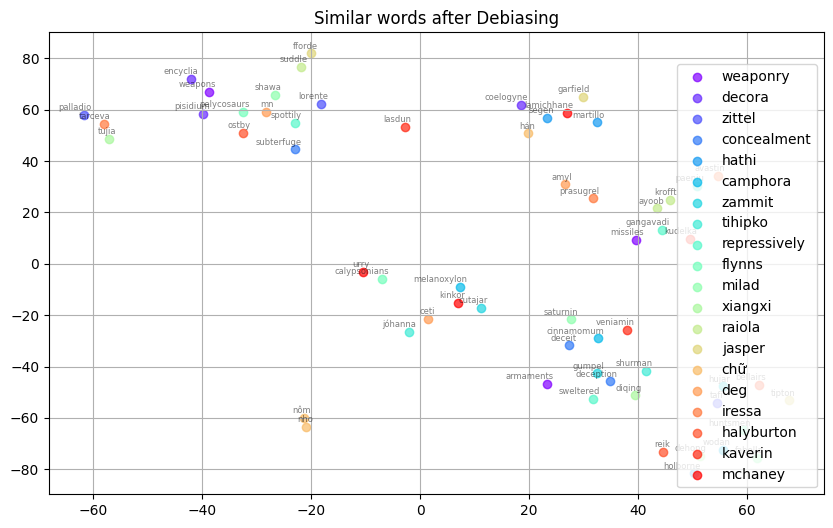

In [25]:
tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [29]:
gendered_names = ["ruth", "charlotte", "abigail", "sophie", "nichole", "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia"]
                 # "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "secretary", "nursery"]
#words_chosen = ["miss", "mrs", "mr", "john", "rachel",
# "wife", "mom", "family", "father", "lady", "he", "she"]

gendered_words_before_and_after=finding_neighbors_before_after(gendered_names, model_original, model_debiased, topn=3)

----------------------------------
word: ruth
 most-similar-before: ('joyce', 'ted', 'doris')
 most-similar-after: ('oyedeji', 'gummed', 'yal')
----------------------------------
word: charlotte
 most-similar-before: ('portland', 'detroit', 'cleveland')
 most-similar-after: ('silverpoint', 'brinell', 'cuffaro')
----------------------------------
word: abigail
 most-similar-before: ('breslin', 'melanie', 'zachary')
 most-similar-after: ('frisch', 'dimasa', 'xiali')
----------------------------------
word: sophie
 most-similar-before: ('kate', 'caroline', 'anna')
 most-similar-after: ('steketee', 'shuar', 'chibnall')
----------------------------------
word: nichole
 most-similar-before: ('nordeman', 'philipson', 'hotaling')
 most-similar-after: ('facere', 'rhacophorus', 'internet')
----------------------------------
word: emma
 most-similar-before: ('helen', 'julia', 'emily')
 most-similar-after: ('certificates', 'frem', 'challinor')
----------------------------------
word: olivia
 most-

/Users/angeladuarte/Python/VersionControl/MT_DebiasingAlgorithms/Visualization.py:93: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


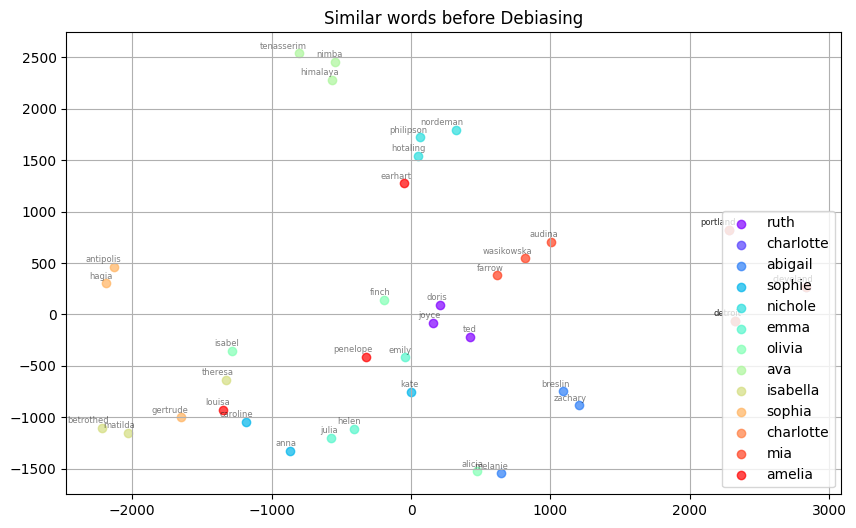

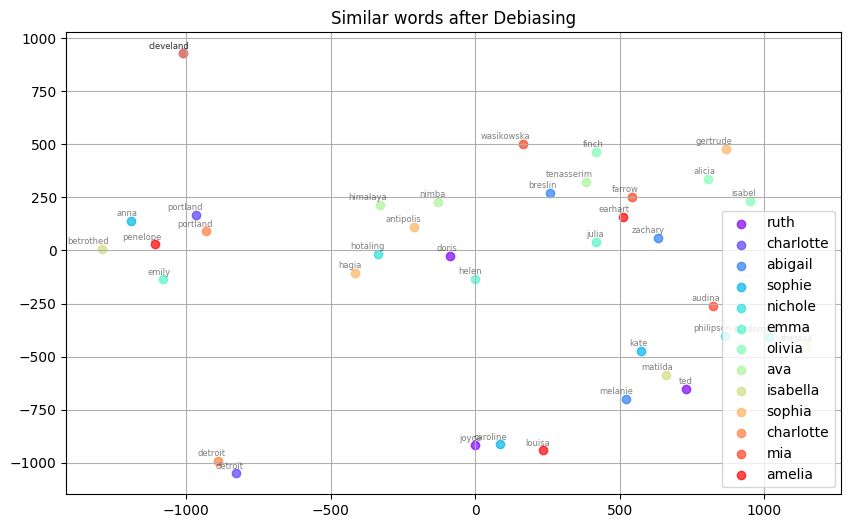

In [30]:
keys2=gendered_names
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing', keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)
